# Two dimensional unequal sampling generalized prolates

This example is not unlike the 2D example of Bronez. We don't have the data, but here goes.

In [79]:
using FFTW, IterTools, Plots, LinearAlgebra, KrylovKit, FINUFFT
using Slepians


""" 

    dfn(x, y, bet)

The underlying Kernel function, equation 22-23 in Chave

# Arguments
    - `x::Number` 1-dimensional location
    - `y::Number` 1-dimensional location
    - `bet::Number` 1-dimensional bandwidth

# Outputs
    - Kernel evaluated between the two points x, y
"""
function new_dfn(x, y, bet)
  x == y && return 2*bet
  sin(2 * pi * bet * sqrt(sum(abs2, x .- y)))/(pi * sqrt(sum(abs2, (x .- y))))
end


""" 

    efn(x, y, f)

The FT matrix

# Arguments
    - `x::Vector` d-dimensional location
    - `y::Vector` d-dimensional location
    - `f::Vector` d-dimensional frequency

# Outputs
    - Frequency-dependent kernel evaluated between the two points x, y
"""
function efn(x, y, f)
    x == y && return 1.0
    f == 0.0 && return 1.0
    exp(-2.0im * pi * f * sum(x .- y))
end

# Product of efn and dfn
function bfn(x, y, f, bet)
    efn(x, y, f) * new_dfn(x, y, bet)
end

bfn (generic function with 1 method)

# Warmup: Missing data problem in 1D

In [80]:
NN = 256
tt = (1.0:NN).^(1.05)

fB = 1.0/2 # *ones(d)
fA = 1.0/16 # *ones(d)

f = 0.0

RA = [new_dfn(xy..., fA) for xy in IterTools.product(tt, tt)]
RB = [bfn(xy..., f, fB) for xy in IterTools.product(tt, tt)]

neig = geneigsolve(x->(RA*x, RB*x), 256, 1, :LM, ishermitian = true, isposdef = true)

([0.9999999999989106], [[-2.3078813389391683e-6, -1.0464479478634023e-5, -3.2451558863839705e-5, -8.271222596788454e-5, -0.0001853890826979761, -0.0003780834166917871, -0.0007158166478329196, -0.0012750418666679386, -0.002156380855409911, -0.003485882742297214  …  0.0002761990691584984, 0.00010623661723774622, 1.4503797151541154e-5, -2.5212080058251466e-5, -3.4517356572592215e-5, -2.920763781052899e-5, -1.9428624724237894e-5, -1.0518299452372883e-5, -4.439124787229744e-6, -1.2103288462955638e-6]], ConvergenceInfo: no converged values after 100 iterations and 3101 applications of the linear map;
norms of residuals are given by (8.180774161936295e-8,).
)

In [81]:
lam_orth, u_orth = gpss_orth(fA, 1, tt, 0.0, beta = fB)

lam, u = gpss(fA, 1, tt, 0.0, beta = fB)

([1.0000000000000036], Complex{Float64}[5.8083894861129e-9 - 0.0im; 3.097101154119072e-8 - 0.0im; … ; 2.048591742102478e-8 - 0.0im; 7.484937915658824e-10 - 0.0im], Cholesky{Complex{Float64},Array{Complex{Float64},2}}(Complex{Float64}[1.0 + 0.0im -0.06534534398152574 - 0.0im … -0.0009102308338316301 - 0.0im 0.0005697795924405583 + 0.0im; 1.0 + 0.0im 0.9978627090035663 + 0.0im … 0.000773787309168558 + 0.0im -0.000688105497034729 - 0.0im; … ; 1.0 + 0.0im 1.0 + 0.0im … 0.9710556103148197 + 0.0im -0.2005260071180715 + 0.0im; 1.0 + 0.0im 1.0 + 0.0im … 1.0 + 0.0im 0.9710520812214699 + 0.0im], 'U', 0))

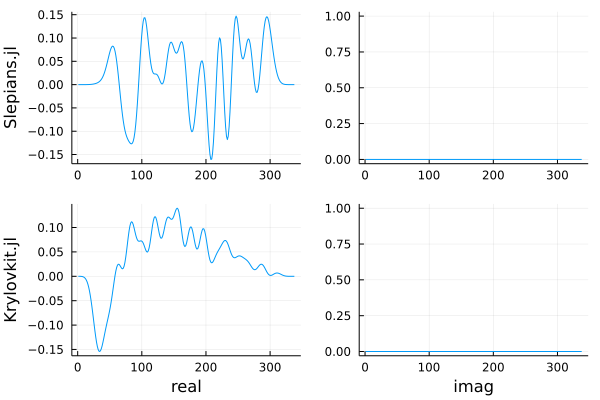

In [82]:
plot(plot(tt, real.(u)), plot(tt, imag.(u)), plot(tt, real.(neig[2][1])), plot(tt, imag.(neig[2][1])),
    layout = (2,2), xlabel = ["" "" "real" "imag"], ylabel = ["Slepians.jl" "" "Krylovkit.jl" ""], 
    legend = false)

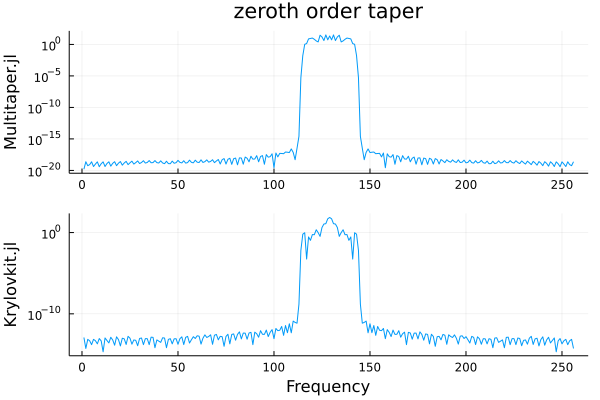

In [83]:
K = 1
w = fA
freqs = LinRange(-0.5, 0.5, NN+1)[1:NN]

ftsleps = mapreduce(k->abs2.(nufft1d3(2*pi*tt, ComplexF64.(u[:,k]), -1, 1e-15, collect(freqs))),hcat, 1:K)

ftsleps2 = abs2.(nufft1d3(2*pi*tt, ComplexF64.(neig[2][1]), -1, 1e-15, collect(freqs)))

plot(plot(ftsleps, yscale = :log10), plot(ftsleps2, yscale = :log10), layout = (2,1), legend = false,
    title = ["zeroth order taper" ""], xlabel = ["" "Frequency"], ylabel = ["Multitaper.jl" "Krylovkit.jl"])

# Warmup: Missing data problem in 2D

This is like the data in the Chave paper, only 2D. Gaps. 

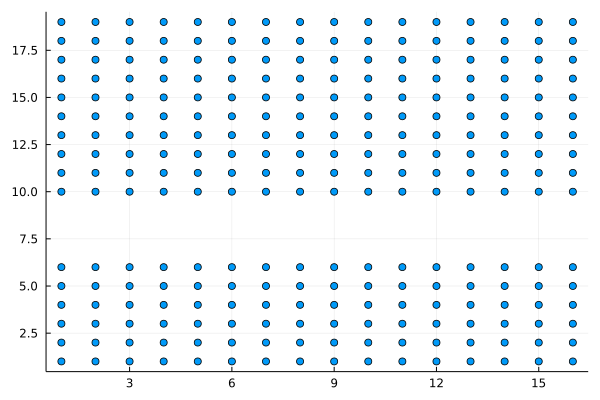

In [84]:
N1 = 16
N2 = 16
t1 = collect(1:N1)
t2 = collect(1:(N2 + 3))[vcat(collect(1:6), collect(10:19))]

mdpts = [(r,t) for r in t1 for t in t2]
mdlocs = [[r,t] for r in t1 for t in t2]

scatter(mdpts, legend = false)

In [85]:
fB = 1.0/2 
fA = 1.0/8 

RA = [dfn(xy..., fA) for xy in IterTools.product(mdlocs, mdlocs)]
RB = [dfn(xy..., fB) for xy in IterTools.product(mdlocs, mdlocs)]

gs = geneigsolve(x->(RA*x, RB*x), 256, 1, :LM, ishermitian = true, isposdef = true) #, howmany = 1, which = :LM, issymmetric = true, T = ComplexF64)

([0.8475367804903419], [[-1463.5850436257956, 959.6391638524874, -131.79284834287043, -751.5213738472737, -475.61361528834743, 94.66612143204206, -604.2149641143502, -674.1901821917786, -229.45870931003992, 117.54311801541682  …  -556.3602182678658, -682.0366030936812, -227.65541704945778, -27.940500664519654, 168.1680907716439, -608.8098384178851, -605.9864739719044, -185.9844628947053, 1062.7164058585824, -1382.4942941286145]], ConvergenceInfo: no converged values after 100 iterations and 3101 applications of the linear map;
norms of residuals are given by (2.885696413069003e-5,).
)

In [86]:
gs[2]

1-element Array{Array{Float64,1},1}:
 [-1463.5850436257956, 959.6391638524874, -131.79284834287043, -751.5213738472737, -475.61361528834743, 94.66612143204206, -604.2149641143502, -674.1901821917786, -229.45870931003992, 117.54311801541682  …  -556.3602182678658, -682.0366030936812, -227.65541704945778, -27.940500664519654, 168.1680907716439, -608.8098384178851, -605.9864739719044, -185.9844628947053, 1062.7164058585824, -1382.4942941286145]

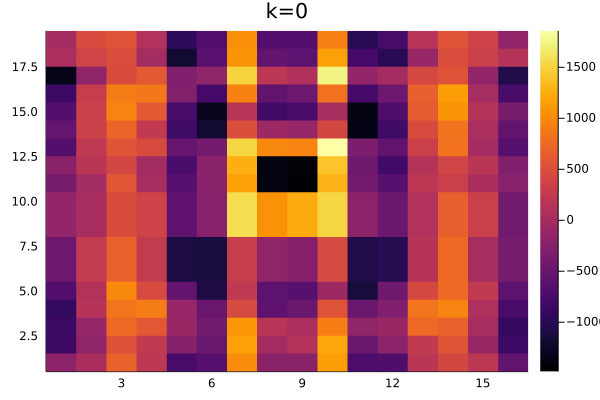

In [87]:
h1 = heatmap(t1, t2, fftshift(reshape(gs[2][1], (16, 16))), title = "k=0")

# General problem: Unequal spacing in array

Here is an array similar to the example in the original Bronez paper. 

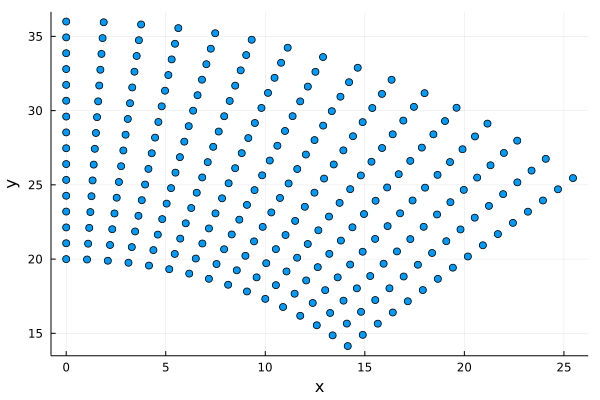

In [88]:
# Set up the array
N1 = 16
N2 = 16

# generate 32 ocncentric circles
rad = collect(LinRange(20,36.0,N1))
thet = collect(LinRange(0.0,45,N2)*pi/180)

pts1 = [(r*sin(t), r*cos(t)) for r in rad for t in thet]

locs1 = [[r*sin(t), r*cos(t)] for r in rad for t in thet]

scatter(pts1, legend = false, xlabel="x", ylabel="y")

In [91]:
# Get the RA and RB matrices, simplifications are provided by Chave, 2020 p 8
d = 2

fB = 1.0/2 # *ones(d)
fA = 1.0/8 # *ones(d)

f = 0.1

RA = [dfn(xy..., fA) for xy in IterTools.product(locs1, locs1)]
RB = [bfn(xy..., f, fB) for xy in IterTools.product(locs1, locs1)]

neig = geneigsolve(x->(RA*x, RB*x), 256, 1, :LM, ishermitian = true, isposdef = true) #, howmany = 1, which = :LM, issymmetric = true, T = ComplexF64)

([0.5054159952114264], Array{Complex{Float64},1}[[0.04718319491729433 + 0.011879415514114644im, 0.05885968692392979 + 0.010802567817465617im, 0.05552322509677071 + 0.01697765541372379im, 0.0584777784504556 + 0.007704745625785107im, 0.06494213626642832 + 0.01825063851070794im, 0.057526060490354615 + 0.01126976455209767im, 0.06814750439372957 + 0.015346510953044918im, 0.0590193402446713 + 0.013321091801241672im, 0.06880842316700127 + 0.014295139784517547im, 0.059306575567043295 + 0.013533100491930319im  …  0.04198281147788485 + 0.04276811767258571im, 0.05361709692911533 + 0.040826321549346525im, 0.06539757125049096 + 0.038524720833054776im, 0.07347954293762625 + 0.03121643742984621im, 0.07099809739251314 + 0.02613402694298794im, 0.06545285946637348 + 0.02394838571556109im, 0.05747859310286349 + 0.02088510994316699im, 0.047804696729351615 + 0.01723123542348587im, 0.04019717672356049 + 0.008642558258809394im, 0.03680098562153297 - 0.006623403828406574im]], ConvergenceInfo: one converged va

In [92]:
xx = hcat(locs1...)

2×256 Array{Float64,2}:
  0.0   1.04672   2.09057   3.12869  …  21.1603  22.6555  24.0887  25.4558
 20.0  19.9726   19.8904   19.7538      29.1246  27.9773  26.7532  25.4558

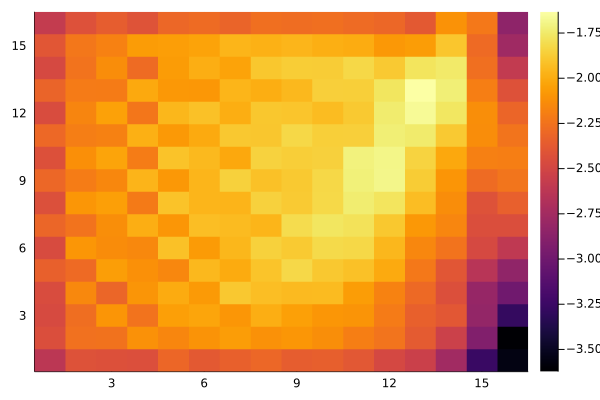

In [93]:
# This is deformed though, so it is hard to visualize with a heatmap
heatmap(log10.(abs2.(reshape(neig[2][1], (16, 16)))))

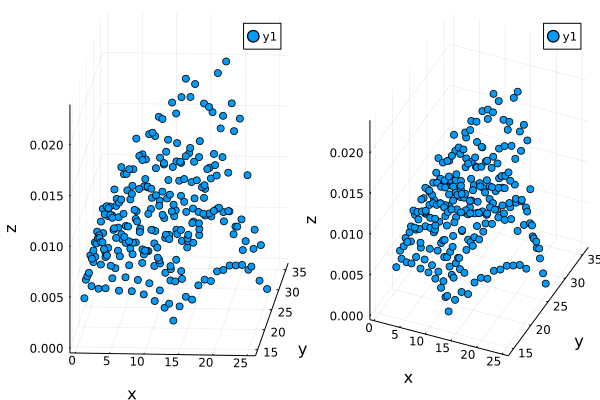

In [94]:
# could do a mesh too
pa = scatter(xx[1,:], xx[2,:], abs2.(neig[2][1]), camera = (10, 35), xlabel = "x", ylabel = "y", zlabel="z")

pb = scatter(xx[1,:], xx[2,:], abs2.(neig[2][1]), camera = (30, 50), xlabel = "x", ylabel = "y", zlabel="z")

plot(pa, pb, layout = (1,2))

In [95]:
freqs1 = LinRange(-1, 1.0, N1)
freqs2 = LinRange(-1, 1.0, N2)

ff = vcat([[xy[1] xy[2]] for xy in IterTools.product(freqs1, freqs2)][:]...)

XX = abs2.(nufft2d1(2*pi*(xx[1,:] .- 12.5)/25., 2*pi*(xx[2,:] .- 12.5)/25., 
        ComplexF64.(neig[2][1]), -1, 1e-15, 2*N1, 2*N2))

32×32 Array{Float64,2}:
 3.30405      0.0241755   0.126214    …  4.15169     2.32213      1.65064
 0.00118194   0.472299    0.0310213      3.96081     2.80715      1.67785
 0.65207      0.0130634   0.201691       3.93121     2.09723      0.475184
 0.102701     0.364703    0.0320801      2.34423     0.377021     0.00563304
 0.278748     0.0508158   0.164266       0.400857    0.0147944    0.0273646
 0.314742     0.102492    0.0441563   …  0.0129148   0.0198159    0.00478458
 0.0014474    0.240029    0.0217743      0.00881079  0.0139364    0.0683364
 0.223297     0.01905     0.172678       0.0334311   0.00797946   0.0577684
 0.207742     0.10012     0.0501621      0.250509    0.00467243   0.0154235
 0.0156784    0.17414     0.00520586     0.10607     0.167524     0.0128153
 0.0568209    0.0709698   0.0264155   …  0.170826    0.00762378   0.069619
 0.095744     0.00775685  0.012227       0.140557    0.129168     0.00551442
 0.109133     0.00350818  0.0027324      0.107553    0.0254625    0

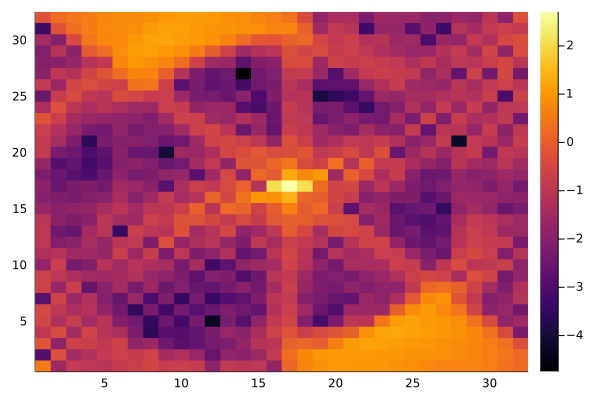

In [96]:
heatmap(log10.(XX))